In [1]:
import tensorflow as tf
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
import requests
from datetime import datetime
# from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE
from functools import reduce
from tensorflow import keras

In [2]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


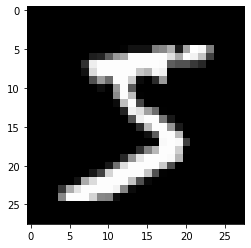

In [6]:
plt.figure()
plt.imshow(x_train[0, :, :, 0], cmap='gray')

In [7]:
BATCH_SIZE = 8
IMG_HEIGHT = 28
IMG_WIDTH = 28

In [8]:
img_width, img_height = IMG_WIDTH, IMG_HEIGHT
channels = 1

In [9]:
input_img = Input(shape=(img_width, img_height, channels))

In [10]:
input_img

<tf.Tensor 'input_1:0' shape=(None, 28, 28, 1) dtype=float32>

In [11]:
conv_shape = (3, 3)

In [12]:
x = Conv2D(16, conv_shape, activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
#
# x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding=maxpad)(x)
# print(x.shape)
#
x = Conv2D(8, conv_shape, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)
print(encoded.shape)

(None, 14, 14, 16)
(None, 7, 7, 8)


In [13]:
encoded

<tf.Tensor 'encoded/Identity:0' shape=(None, 7, 7, 8) dtype=float32>

In [14]:
x = Conv2D(8, conv_shape, activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
print(x.shape)
# x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# #
# x = Conv2D(16, conv_shape, activation='relu')(x)
# x = UpSampling2D((2, 2))(x)
x = Conv2D(16, conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
print(x.shape)
decoded = Conv2D(channels, conv_shape, activation='sigmoid', padding='same')(x)
decoded.shape

(None, 14, 14, 8)
(None, 28, 28, 16)


TensorShape([None, 28, 28, 1])

In [15]:
decoded

<tf.Tensor 'conv2d_4/Identity:0' shape=(None, 28, 28, 1) dtype=float32>

dimensionality reduction

In [16]:
IMG_HEIGHT * IMG_WIDTH / int(reduce(lambda x, y: x*y, np.asarray(encoded.shape[1:])))

2.0

In [17]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
encoded (MaxPooling2D)       (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 8)         0     

In [18]:
log_dir = "./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_cb = TensorBoard(
    log_dir=log_dir, 
    profile_batch=0)

es_cb = EarlyStopping(
    monitor='val_loss',
    verbose=True,
    patience=12,
    min_delta=0.0001, 
    restore_best_weights=True)

lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=True,
    patience=8,
    mi_delta=0.0001)

cb = [tb_cb, es_cb, lr_cb]

In [19]:
epochs = 250

autoencoder_train = autoencoder.fit(
    x=x_train, 
    y=x_train,
    epochs=epochs, 
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=cb)

Train on 60000 samples, validate on 10000 samples
Epoch 1/250
60000/60000 [==============================] - 10s 165us/sample - loss: 0.2369 - val_loss: 0.2301
Epoch 2/250
60000/60000 [==============================] - 8s 127us/sample - loss: 0.2201 - val_loss: 0.2043
Epoch 3/250
60000/60000 [==============================] - 8s 128us/sample - loss: 0.1722 - val_loss: 0.1461
Epoch 4/250
60000/60000 [==============================] - 8s 126us/sample - loss: 0.1331 - val_loss: 0.1271
Epoch 5/250
60000/60000 [==============================] - 8s 127us/sample - loss: 0.1208 - val_loss: 0.1179
Epoch 6/250
60000/60000 [==============================] - 8s 127us/sample - loss: 0.1108 - val_loss: 0.1059
Epoch 7/250
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0978 - val_loss: 0.0921
Epoch 8/250
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0851 - val_loss: 0.0801
Epoch 9/250
60000/60000 [==============================] - 8s 127us/sample - 

60000/60000 [==============================] - 8s 126us/sample - loss: 0.0161 - val_loss: 0.0157
Epoch 76/250
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0160 - val_loss: 0.0156
Epoch 77/250
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0159 - val_loss: 0.0155
Epoch 78/250
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0158 - val_loss: 0.0154
Epoch 79/250
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0157 - val_loss: 0.0153
Epoch 80/250
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0156 - val_loss: 0.0152
Epoch 81/250
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0155 - val_loss: 0.0151
Epoch 82/250
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0154 - val_loss: 0.0150
Epoch 83/250
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0154 - val_loss: 0.0149
Epoch 84/250
60000/6000

Epoch 223/250
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0103 - val_loss: 0.0100
Epoch 224/250
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0103 - val_loss: 0.0100
Epoch 225/250
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0103 - val_loss: 0.0100
Epoch 226/250
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0103 - val_loss: 0.0100
Epoch 227/250
60000/60000 [==============================] - 8s 136us/sample - loss: 0.0103 - val_loss: 0.0099
Epoch 228/250
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0102 - val_loss: 0.0099
Epoch 229/250
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0102 - val_loss: 0.0099
Epoch 230/250
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0102 - val_loss: 0.0099
Epoch 231/250
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0102 - val_loss: 0.0099
E

In [20]:
saved = False
if not saved:
    autoencoder.save('./ae_model_{}.hdf5'.format(epochs))
    saved = True

In [21]:
id_test = np.random.choice(range(x_test.shape[0]), 10)

In [22]:
x_test[0,:,:,:].shape

(28, 28, 1)

In [23]:
pred = autoencoder.predict(x_test[0:1,:,:,:])

In [24]:
pred.shape

(1, 28, 28, 1)

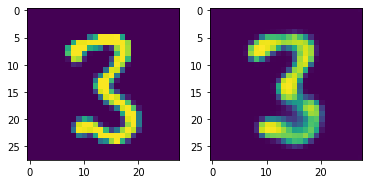

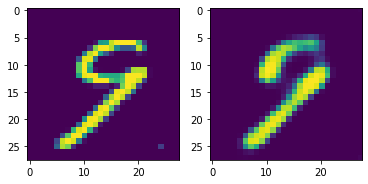

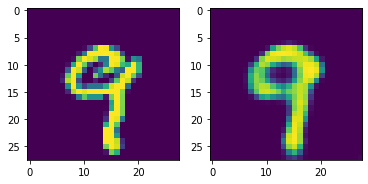

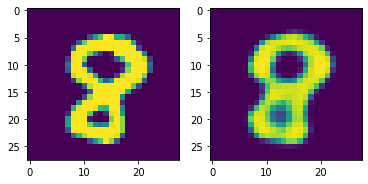

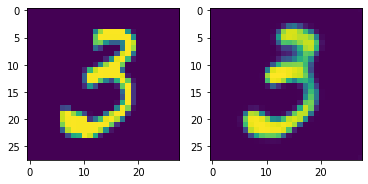

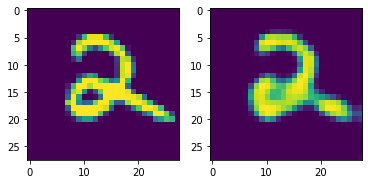

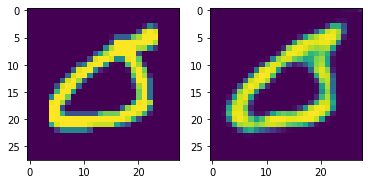

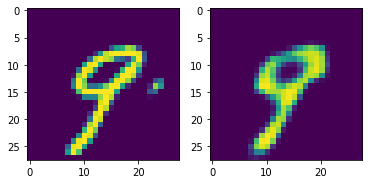

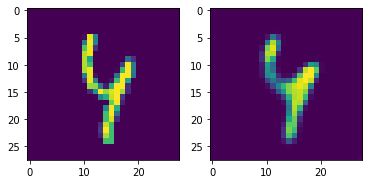

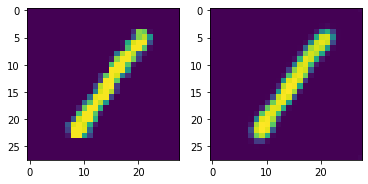

In [25]:
for i in id_test:
    tmp_im = x_test[i:i+1,:,:,:]
    tmp_pred = autoencoder.predict(tmp_im)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(tmp_im[0,:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(tmp_pred[0,:,:,0])    